1. Set up & train the model
    - 1.1 Load the data
    - 1.2 Map the label to number
    - 1.3 Split training and testing dataset
    - 1.4 Define a Dataset class
    - 1.5 Load the data
    - 1.6 Prepare the ResNet18 model
    - 1.7 training process
2. Evaluate the model
    - 2.1 Plot the confusion matrix
    - 2.2 Implement the Grad Cam

### 1.Set up & train the model

#### 1.1 Load the data

In [1]:
import os
from pathlib import Path

# read the dataset
root_dir = Path("Aerial_Landscapes")
img_extensions = [".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff"]

# store image paths and corresponding labels
image_paths = []

for class_dir in root_dir.iterdir():
    if class_dir.is_dir():
        label = class_dir.name  # lable is the name of the folder
        for img_path in class_dir.iterdir():
            if img_path.suffix.lower() in img_extensions:
                image_paths.append((str(img_path), label))

# print the first 5 image paths and their labels
for path, label in image_paths[:5]:
    print(f"image_path: {path}, label: {label}")


image_path: Aerial_Landscapes\Agriculture\001.jpg, label: Agriculture
image_path: Aerial_Landscapes\Agriculture\002.jpg, label: Agriculture
image_path: Aerial_Landscapes\Agriculture\003.jpg, label: Agriculture
image_path: Aerial_Landscapes\Agriculture\004.jpg, label: Agriculture
image_path: Aerial_Landscapes\Agriculture\005.jpg, label: Agriculture


#### 1.2 Map the label to number

In [2]:
categories = [
    "Agriculture",   # 0
    "Airport",       # 1
    "Beach",         # 2
    "City",          # 3
    "Desert",        # 4
    "Forest",        # 5
    "Grassland",     # 6
    "Highway",       # 7
    "Lake",          # 8
    "Mountain",      # 9
    "Parking",       #10
    "Port",          #11
    "Railway",       #12
    "Residential",   #13
    "River"          #14
]

# map categories to numerical labels
label_to_id = {label: idx for idx, label in enumerate(categories)}

# convert image paths to numerical labels
image_path_labeled = []
for path, label in image_paths:
    label_id = label_to_id[label]
    image_path_labeled.append((path, label_id))

for path, label_id in image_path_labeled[:5]:
    print(f"image path: {path}, numerical labels: {label_id}")



image path: Aerial_Landscapes\Agriculture\001.jpg, numerical labels: 0
image path: Aerial_Landscapes\Agriculture\002.jpg, numerical labels: 0
image path: Aerial_Landscapes\Agriculture\003.jpg, numerical labels: 0
image path: Aerial_Landscapes\Agriculture\004.jpg, numerical labels: 0
image path: Aerial_Landscapes\Agriculture\005.jpg, numerical labels: 0


In [3]:
from collections import Counter

label_ids = [label_id for _, label_id in image_path_labeled]
label_count = Counter(label_ids)

for label_id in sorted(label_count):
    print(f"Label ID: {label_id}, image_number: {label_count[label_id]}")


Label ID: 0, image_number: 800
Label ID: 1, image_number: 800
Label ID: 2, image_number: 800
Label ID: 3, image_number: 800
Label ID: 4, image_number: 800
Label ID: 5, image_number: 800
Label ID: 6, image_number: 800
Label ID: 7, image_number: 800
Label ID: 8, image_number: 800
Label ID: 9, image_number: 800
Label ID: 10, image_number: 800
Label ID: 11, image_number: 800
Label ID: 12, image_number: 800
Label ID: 13, image_number: 800
Label ID: 14, image_number: 800


#### 1.3 Split training and testing dataset

In [4]:
import random
from collections import defaultdict

# makesure the dataset is reproducible
random.seed(42)

class_to_images = defaultdict(list)
for path, label_id in image_path_labeled:
    class_to_images[label_id].append(path)

train_data = []
test_data = []

# split the dataset into train and test sets (80% train, 20% test)
for label_id, images in class_to_images.items():
    random.shuffle(images)
    split_idx = int(0.8 * len(images))
    train_imgs = images[:split_idx]
    test_imgs = images[split_idx:]
    
    train_data += [(img, label_id) for img in train_imgs]
    test_data += [(img, label_id) for img in test_imgs]

#### 1.4 Define a Dataset class

In [15]:
from torch.utils.data import Dataset
from PIL import Image
import torch

class RemoteSensingDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        image_path, label = self.data[idx]
        image = Image.open(image_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label


#### 1.5 Load the data

In [16]:
from torchvision import transforms
from torch.utils.data import DataLoader

# does not resize the image
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

train_dataset = RemoteSensingDataset(train_data, transform=transform)
test_dataset = RemoteSensingDataset(test_data, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


#### 1.6 Prepare the ResNet18 model for classification

In [5]:
import torch
import torch.nn as nn
from torchvision.models import resnet18

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [6]:
# use the pretrained ResNet18 model
model = resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 15)  # 15 classes
model = model.to(device)

C:\Users\User\AppData\Roaming\Python\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\User\AppData\Roaming\Python\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


#### 1.7 Set the optimizer, and train the model

In [7]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [17]:
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = outputs.max(1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_loss = total_loss / len(train_loader)
    train_acc = 100 * correct / total
    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")

# save the model
torch.save(model.state_dict(), "resnet18_classify_landscapes.pth")
print("model saved!")

Epoch 1/10 | Train Loss: 0.3887 | Train Acc: 89.14%
Epoch 2/10 | Train Loss: 0.0802 | Train Acc: 97.85%
Epoch 3/10 | Train Loss: 0.0467 | Train Acc: 98.75%
Epoch 4/10 | Train Loss: 0.0298 | Train Acc: 99.33%
Epoch 5/10 | Train Loss: 0.0401 | Train Acc: 98.89%
Epoch 6/10 | Train Loss: 0.0279 | Train Acc: 99.19%
Epoch 7/10 | Train Loss: 0.0219 | Train Acc: 99.41%
Epoch 8/10 | Train Loss: 0.0146 | Train Acc: 99.56%
Epoch 9/10 | Train Loss: 0.0277 | Train Acc: 99.18%
Epoch 10/10 | Train Loss: 0.0257 | Train Acc: 99.35%
model saved!


### 2. Evaluate the model

#### 2.1 Plot the confusion matrix

In [8]:
import torch.nn as nn
from torchvision.models import resnet18
import torch

# load the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = resnet18(pretrained=False) 
model.fc = nn.Linear(model.fc.in_features, 15)  # 15 categories
model.load_state_dict(torch.load("resnet18_classify_landscapes.pth"))
model = model.to(device)
model.eval()
print()

C:\Users\User\AppData\Roaming\Python\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
D:\Temp\ipykernel_4808\369994539.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_

In [21]:
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report

# evaluate the model
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())


print("Precision:", precision_score(all_labels, all_preds, average='macro'))
print("Recall:", recall_score(all_labels, all_preds, average='macro'))
print("F1 Score:", f1_score(all_labels, all_preds, average='macro'))


print(classification_report(all_labels, all_preds))


Precision: 0.971439176634481
Recall: 0.9708333333333334
F1 Score: 0.9708561037711066
              precision    recall  f1-score   support

           0       0.98      0.96      0.97       160
           1       0.93      0.97      0.95       160
           2       0.98      0.98      0.98       160
           3       0.99      0.94      0.96       160
           4       0.99      0.96      0.97       160
           5       0.99      0.97      0.98       160
           6       0.95      1.00      0.98       160
           7       0.99      0.96      0.97       160
           8       0.99      0.97      0.98       160
           9       0.94      0.99      0.96       160
          10       0.95      1.00      0.98       160
          11       0.99      0.99      0.99       160
          12       0.96      0.97      0.97       160
          13       0.99      0.93      0.96       160
          14       0.96      0.96      0.96       160

    accuracy                           0.97      

In [9]:
id_to_label = {idx: label for idx, label in enumerate(categories)}

for i in range(5):
    print(f"ID: {i}, label: {id_to_label[i]}")

ID: 0, label: Agriculture
ID: 1, label: Airport
ID: 2, label: Beach
ID: 3, label: City
ID: 4, label: Desert


#### 2.2 Implement the Grad Cam

In [10]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from torchvision import transforms

def visualize_with_gradcam(img_path, model, transform, id_to_label, device):
    # read the image
    image_pil = Image.open(img_path).convert("RGB")
    true_label = os.path.basename(os.path.dirname(img_path))  # read the true label from the folder name

    # image preprocessing
    image_tensor = transform(image_pil).unsqueeze(0).to(device)
    image_np = np.array(image_pil.resize((256, 256))) / 255.0

    # model prediction
    with torch.no_grad():
        output = model(image_tensor)
        _, predicted = torch.max(output, 1)
    predicted_label = id_to_label[predicted.item()]

    # Grad-CAM
    target_layers = [model.layer4[-1]]
    cam = GradCAM(model=model, target_layers=target_layers)
    targets = [ClassifierOutputTarget(predicted.item())]
    grayscale_cam = cam(input_tensor=image_tensor, targets=targets)[0, :]
    visualization = show_cam_on_image(image_np, grayscale_cam, use_rgb=True)

    # plot the results
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    axes[0].imshow(image_pil)
    axes[0].axis('off')
    axes[0].set_title(f"Original Image\nTrue label: {true_label}", fontsize=10)
    axes[1].imshow(visualization)
    axes[1].axis('off')
    axes[1].set_title(f"Grad-CAM\nPredicted label: {predicted_label}", fontsize=10)
    plt.tight_layout()
    plt.show()


In [12]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

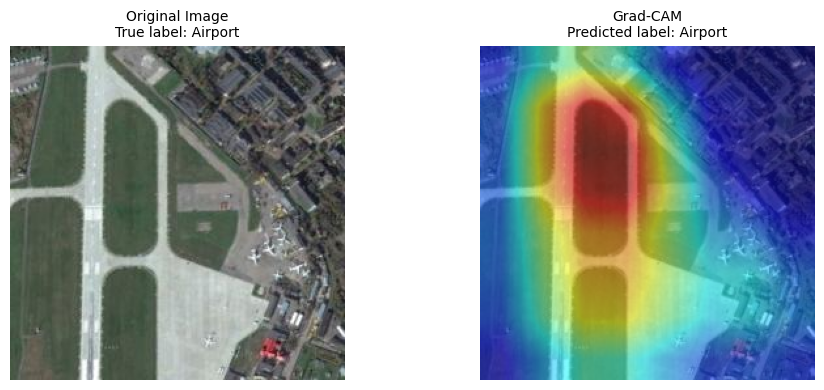

In [13]:
visualize_with_gradcam(
    img_path="Aerial_Landscapes/Airport/800.jpg",
    model=model,
    transform=transform,
    id_to_label=id_to_label,
    device=device
)


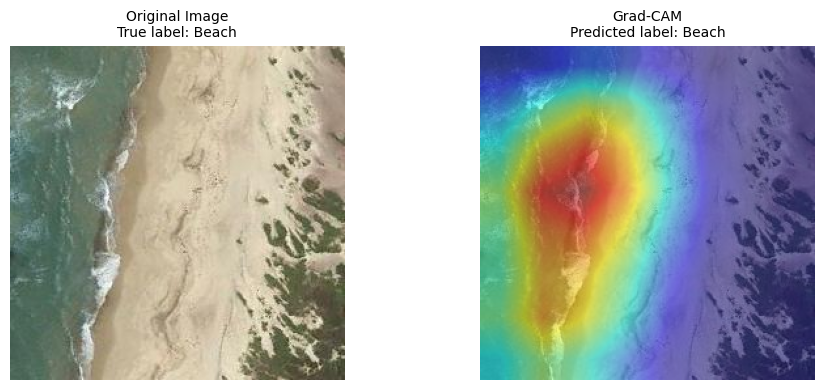

In [14]:
visualize_with_gradcam(
    img_path="Aerial_Landscapes/Beach/004.jpg",
    model=model,
    transform=transform,
    id_to_label=id_to_label,
    device=device
)

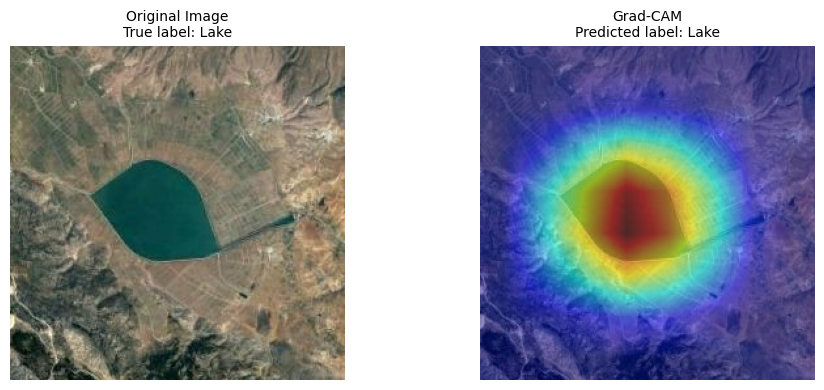

In [15]:
visualize_with_gradcam(
    img_path="Aerial_Landscapes/Lake/001.jpg",
    model=model,
    transform=transform,
    id_to_label=id_to_label,
    device=device
)

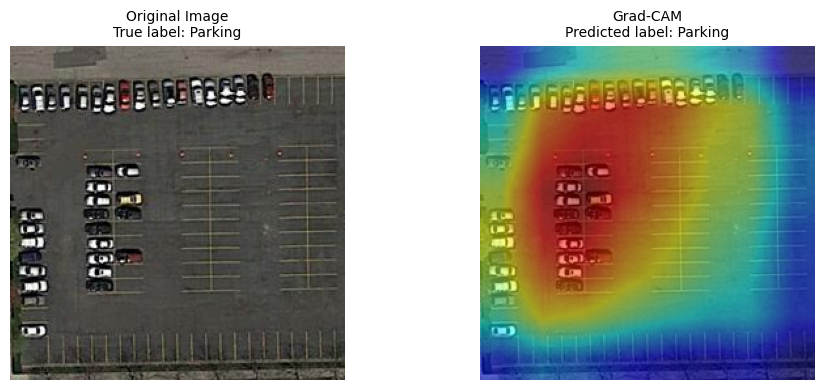

In [16]:
visualize_with_gradcam(
    img_path="Aerial_Landscapes/Parking/005.jpg",
    model=model,
    transform=transform,
    id_to_label=id_to_label,
    device=device
)